<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/RecercaExtra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import torch
import cv2
import csv
import random
import numpy as np
import ast
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl
import json
import sys
import ast
import shutil

from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io
from google.colab import drive

# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'
DOWNLOAD = False
PUT = False
RUN = 22

drive.mount('/content/drive')

TESTING_FEATURES_FILE = '/content/drive/MyDrive/Runs/Ham10000Resnet152Multiclass/'+str(RUN)+'/Features/testing_features.txt'
TRAINING_FEATURES_FILE = '/content/drive/MyDrive/Runs/Ham10000Resnet152Multiclass/'+str(RUN)+'/Features/training_features.txt'
HAIRIMG = '/content/drive/MyDrive/Runs/Ham10000Resnet152Multiclass/'+str(RUN)+'/HairFeature/'
NOHAIRIMG =  '/content/drive/MyDrive/Runs/Ham10000Resnet152Multiclass/'+str(RUN)+'/NoHairFeature/'
FOLDERS = ['nv','bcc','bkl','akiec','vasc','mel','df']

if PUT:
  if os.path.exists(HAIRIMG):
      shutil.rmtree(HAIRIMG)
  if os.path.exists(NOHAIRIMG):
      shutil.rmtree(NOHAIRIMG)

  os.makedirs(HAIRIMG,exist_ok=True)
  os.makedirs(NOHAIRIMG,exist_ok=True)

  for i in FOLDERS:
    os.makedirs(HAIRIMG+i+'/',exist_ok=True)
    os.makedirs(NOHAIRIMG+i+'/',exist_ok=True)



if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')


IMAGE_PATHS1 = glob('/content/sample_data/HAM10000_images_part_1/*.jpg')
IMAGE_PATHS2 = glob('/content/sample_data/HAM10000_images_part_2/*.jpg')
IMAGE_PATHS3 = glob('/content/sample_data/ham10000_images_part_1/*.jpg')
IMAGE_PATHS4 = glob('/content/sample_data/ham10000_images_part_2/*.jpg')
IMAGE_PATHS = IMAGE_PATHS2
# PATH_TRAINING_DISTANCES = "/content/drive/MyDrive/Features/Embeddings/embeddings_pesos_resnet152multiclass_3.pt.txt" #embeddings training
# DISTANCES_IMAGES = "/content/drive/MyDrive/Features/Dist/1/distances.txt" #distàncies de totes les imatges de test

IMG_PATH = '/content/sample_data/HAM10000_images_part_2/'

hair_img_numbers = [27790,27010,25415,25606,28732,26193,26947,27970,24891,26315,26392,27199,26127,27970,24891,26315,26392,27199,26127,26303,29097,25282,28642,27295,28424,26184,24779,26998,24342,26615
               ,26651,28921, 28777, 26292, 25746, 25216, 24803, 24411, 26879, 26286, 25746, 25526, 25466,33886,33569,30693,30643,30768,30426,34235,30064,30624,32942,33738,34297,
               33337,33067,31057,30178,31172,31178,34085,31775,31096,30882,33374,33450,32266,29954,33380,29937,30853,32664,29780,
               33688,30353,30920,33449,34295,31862,32054,32198,29569,32808,24331,34314,32307,30743,32477,29390,33683,30774,33418,29341,32200,30110]

nohair_img_numbers = [29071,31385,33832,31549,27054,28724,29932,30730,26626,26702,31108,24951,28026,27300,27663,30445,25312,29040,
                      28977,25046,25818,33146,31641,25971,31309,33554]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if PUT:
  for i in hair_img_numbers:
    diagnosis = metadates.loc[metadates['image_id'] == 'ISIC_00'+str(i), 'dx'].values

    if os.path.exists(IMG_PATH+'ISIC_00'+str(i)+'.jpg'):
      shutil.copy(IMG_PATH+'ISIC_00'+str(i)+'.jpg',HAIRIMG+str(diagnosis[0])+'/')
    else:
      shutil.copy('/content/sample_data/HAM10000_images_part_1/'+'ISIC_00'+str(i)+'.jpg',HAIRIMG+str(diagnosis[0])+'/')

  for i in nohair_img_numbers:
    diagnosis = metadates.loc[metadates['image_id'] == 'ISIC_00'+str(i), 'dx'].values
    if os.path.exists(IMG_PATH+'ISIC_00'+str(i)+'.jpg'):
      shutil.copy(IMG_PATH+'ISIC_00'+str(i)+'.jpg',NOHAIRIMG+str(diagnosis[0])+'/')
    else:
      shutil.copy('/content/sample_data/HAM10000_images_part_1/'+'ISIC_00'+str(i)+'.jpg',NOHAIRIMG+str(diagnosis[0])+'/')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
def guarda_features_hairy():
    features = []
    for j in hair_img_numbers:
        name = 'ISIC_00'+str(j)+'.jpg'
        with open(TESTING_FEATURES_FILE, newline='') as ftst:
            test_features = csv.DictReader(ftst, delimiter=',')

            for row in test_features:
                if row['Image Name'] == name:
                    features.append((ast.literal_eval(row['FC Input']),row['Label']))

        with open(TRAINING_FEATURES_FILE, newline='') as ftr:
            tr_features = csv.DictReader(ftr, delimiter=',')

            for row in tr_features:
                if row['Image Name'] == name:
                    features.append((ast.literal_eval(row['FC Input']),row['Label']))

    with open(HAIRIMG+'Hairy_features.txt', 'w') as out_file:
        out_file.write(str(features))


def guarda_features_dif():
  features = []
  for j in nohair_img_numbers:
        name = 'ISIC_00'+str(j)+'.jpg'
        with open(TESTING_FEATURES_FILE, newline='') as ftst:
            test_features = csv.DictReader(ftst, delimiter=',')

            for row in test_features:
                if row['Image Name'] == name:
                    features.append((ast.literal_eval(row['FC Input']),row['Label']))

        with open(TRAINING_FEATURES_FILE, newline='') as ftr:
            tr_features = csv.DictReader(ftr, delimiter=',')

            for row in tr_features:
                if row['Image Name'] == name:
                    features.append((ast.literal_eval(row['FC Input']),row['Label']))

  with open(NOHAIRIMG+'noHairy_features.txt', 'w') as out_file:
      out_file.write(str(features))

# guarda_features_hairy()
# guarda_features_dif()

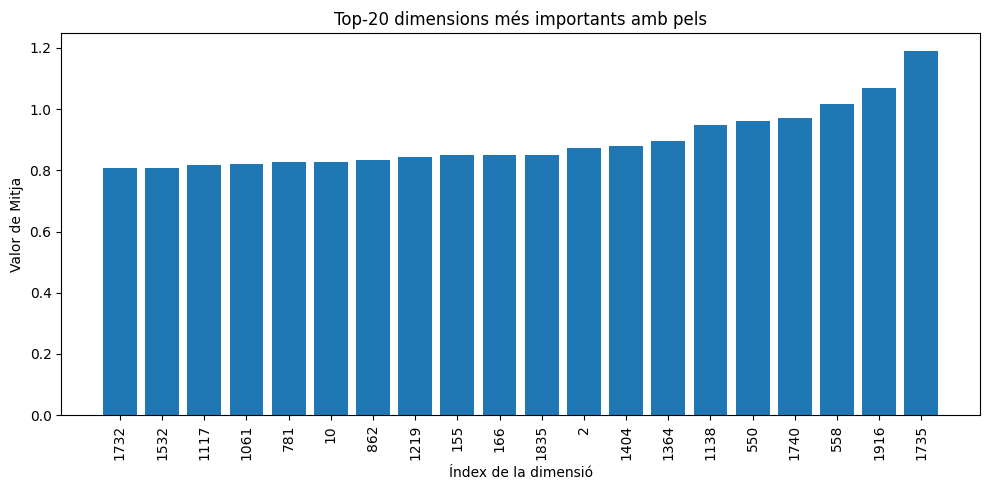

In [47]:
import itertools

classe = "mel"
dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

importance_scores = []

with open(HAIRIMG+'Hairy_features.txt','r') as ft:
  hairy = ast.literal_eval(ft.read())

  for i in hairy:
    if dict_illnesses[int(i[1])] == classe:
      importance_scores.append(i[0]) #i[0] conté el vector de caracteristiques

  importance_scores = np.array(importance_scores)
  importance_scores = np.mean(np.abs(importance_scores), axis=0)


top_k= 20
top_indices1 = np.argsort(importance_scores)[-top_k:]

plt.figure(figsize=(10, 5))
plt.bar(range(top_k), importance_scores[top_indices1])
plt.xticks(range(top_k), top_indices1, rotation=90)
plt.title(f"Top-{top_k} dimensions més importants amb pels")
plt.xlabel("Índex de la dimensió")
plt.ylabel("Valor de Mitja")
plt.tight_layout()
plt.show()

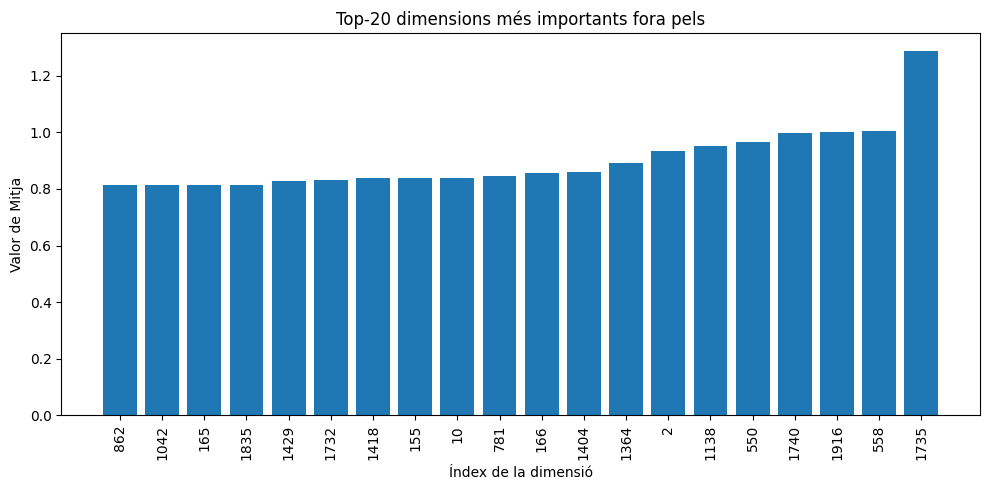

In [48]:
import itertools

classe = "mel"
dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

importance_scores_nohair = []

with open(NOHAIRIMG+'noHairy_features.txt','r') as ft:
  nohairy = ast.literal_eval(ft.read())

  for i in nohairy:
    if dict_illnesses[int(i[1])] == classe:
      importance_scores_nohair.append(i[0]) #i[0] conté el vector de caracteristiques

  importance_scores_nohair = np.array(importance_scores_nohair)
  importance_scores_nohair = np.mean(np.abs(importance_scores_nohair), axis=0)


top_k= 20
top_indices2 = np.argsort(importance_scores_nohair)[-top_k:]

plt.figure(figsize=(10, 5))
plt.bar(range(top_k), importance_scores_nohair[top_indices2])
plt.xticks(range(top_k), top_indices2, rotation=90)
plt.title(f"Top-{top_k} dimensions més importants fora pels")
plt.xlabel("Índex de la dimensió")
plt.ylabel("Valor de Mitja")
plt.tight_layout()
plt.show()

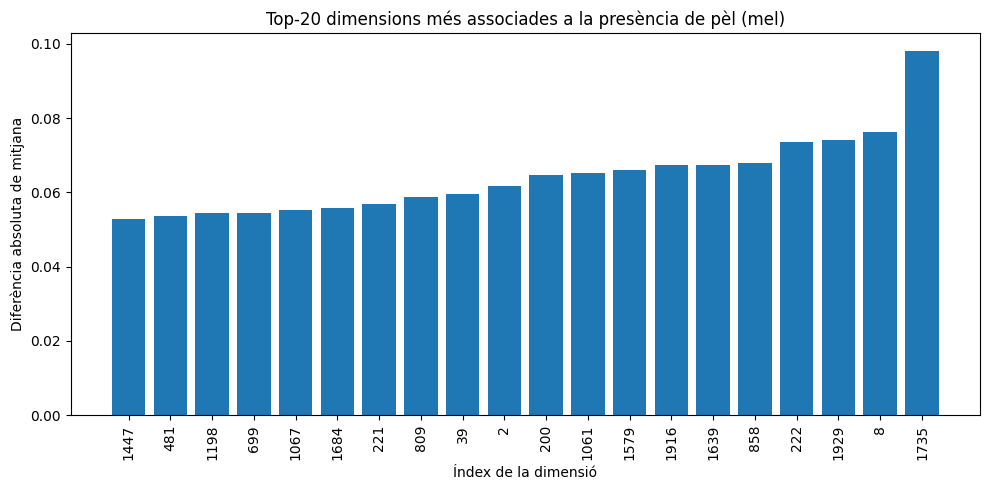

In [49]:
diff = np.abs(importance_scores - importance_scores_nohair)

# Selecciona les top-20 diferències més grans
top_k = 20
top_diff_indices = np.argsort(diff)[-top_k:]

# Visualitza-les
plt.figure(figsize=(10, 5))
plt.bar(range(top_k), diff[top_diff_indices])
plt.xticks(range(top_k), top_diff_indices, rotation=90)
plt.title(f"Top-{top_k} dimensions més associades a la presència de pèl ({classe})")
plt.xlabel("Índex de la dimensió")
plt.ylabel("Diferència absoluta de mitjana")
plt.tight_layout()
plt.show()

In [50]:
for i in top_indices2:
  if i not in top_indices1:
    print(i)

1042
165
1429
1418


Pertanyents a l'histograma de pels i no al segon: \\
· 1219 \\
· 1532 \\
· 862 \\
· 1732 \\
· 1372

In [ ]:

# for path in IMAGE_PATHS:  # Puedes cambiar el número de imágenes que deseas ver
#     img = Image.open(path)
#     clear_output(wait=True)  # Limpia la celda para mostrar la siguiente imagen
#     display(img)
#     print(path)
#     time.sleep(5)  # Espera 2 segundos


In [ ]:
# !mkdir -p ~/.kaggle
# !mv /content/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# print(vector_features)